Ahmad Luay Adnani

# Generative AI for Personalized E-commerce Customer Segmentation

---

# 1 - Introduction

## 1.1 Background

theLook E-commerce, boasting a diverse product catalog and growing customer base, faces the rising complexity of understanding individual customer needs and preferences. Existing segmentation strategies based on basic data points like orders, spending, and returns provide valuable insights, but lack the power to reveal hidden patterns, predict future behavior, and personalize experiences effectively.Generative AI holds immense potential to transform theLook's customer segmentation approach.

## 1.2 Objective

theLook E-commerce seeks to harness the transformative power of generative AI to **adjust marketing strategies based on customer behaviours**. This strategy will unlock deeper customer insights, enable data-driven personalization, and empower the company to predict and respond to customer needs proactively, ultimately driving significant and sustainable business growth and competitive advantage in the evolving e-commerce landscape.

By setting this objective, theLook positions itself at the forefront of customer-centric innovation, leveraging cutting-edge AI technology to build deeper customer relationships and unlock unparalleled business potential.

---

# 2 - Import Library

In [ ]:
#!pip install feature_engine langchain openai

In [ ]:
# Import Libraries
from google.cloud import bigquery
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

project_id = "ctelkom"
client = bigquery.Client(project=project_id)

Authenticated


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import warnings
from feature_engine.outliers import Winsorizer

from scipy.stats import skew
from statsmodels.stats.outliers_influence import variance_inflation_factor

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from langchain.chains import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate

import pickle
import json

warnings.filterwarnings('ignore')

---

# 3 - Data Loading

The dataset used is  [theLook eCommerce public dataset](https://console.cloud.google.com/marketplace/product/bigquery-public-data/thelook-ecommerce).

In [ ]:
# Query
query = (client.query('''
SELECT
user_id, order_id, sale_price, created_at, status
FROM `bigquery-public-data.thelook_ecommerce.order_items`
WHERE created_at BETWEEN "2023-01-01" AND "2024-02-21";
''').to_dataframe())

In [ ]:
# save to .csv file
query.to_csv('ecommerce-cluster.csv')

In [ ]:
# Data loading
df = pd.read_csv('ecommerce-cluster.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
df.head()

,user_id,order_id,sale_price,created_at,status
0,90554,113027,0.02,2023-02-06 05:08:11+00:00,Cancelled
1,28236,35212,0.49,2023-09-22 09:23:58+00:00,Complete
2,54622,68278,0.49,2023-02-23 16:33:17+00:00,Complete
3,53582,67023,0.49,2023-03-06 14:54:14+00:00,Returned
4,56701,70863,0.49,2023-11-10 07:49:07+00:00,Returned


1. `user_id:` This column represents a unique identifier for each user or customer. It is used to associate each order with a specific customer.
2. `order_id:` This column represents a unique identifier for each order. It is used to differentiate between different transactions or purchases made by users.
3. `sale_price:` This column represents the sale price of the product associated with the order. The sale price indicates the amount paid by the customer for the respective product.
4. `created_at:` This column represents the timestamp indicating when the order was created or placed. It provides information about the date and time when the customer initiated the purchase.
5. `status:` This column indicates the current status of the order. The possible values include:
  - "Cancelled": The order was canceled before it was fulfilled.
  - "Shipped": The order has been shipped to the customer.
  - "Complete": The order has been successfully processed and completed.
  - "Processing": The order is currently being processed and has not yet been shipped or completed.
  - "Returned": The order was returned by the customer, indicating a reversal of the sale.

In [ ]:
df.shape

(99059, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99059 entries, 0 to 99058
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     99059 non-null  int64  
 1   order_id    99059 non-null  int64  
 2   sale_price  99059 non-null  float64
 3   created_at  99059 non-null  object 
 4   status      99059 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 3.8+ MB


In [ ]:
# Descriptive Statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,99059.0,50097.587549,28926.152268,1.00,25067.000000,50085.000000,75301.000000,99998.0
order_id,99059.0,62558.164357,36156.332158,1.00,31188.500000,62691.000000,94099.000000,124875.0
sale_price,99059.0,59.914124,67.515279,0.02,24.950001,39.990002,69.989998,999.0


---

# 4 - Exploratory Data Analysis

We intend to compute features such as the total **number of orders per customer**, **average spending per custome**r, and the **return ratio**, calculated as the total number of returns divided by the number of orders.

##  4.1 Status

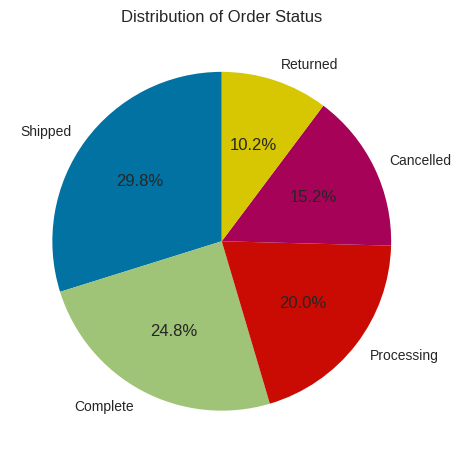

In [ ]:
# Create a pie chart for the 'status' column
status_counts = df['status'].value_counts()
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Order Status')
plt.show()

From the visualization above there are **10.2%** orders returned,  suggests that a portion of completed orders has been sent back. Monitoring return rates can provide insights into product quality, customer satisfaction, or potential issues with the fulfillment process.

## 4.2 Number of Orders

Calculating total number of orders per customer

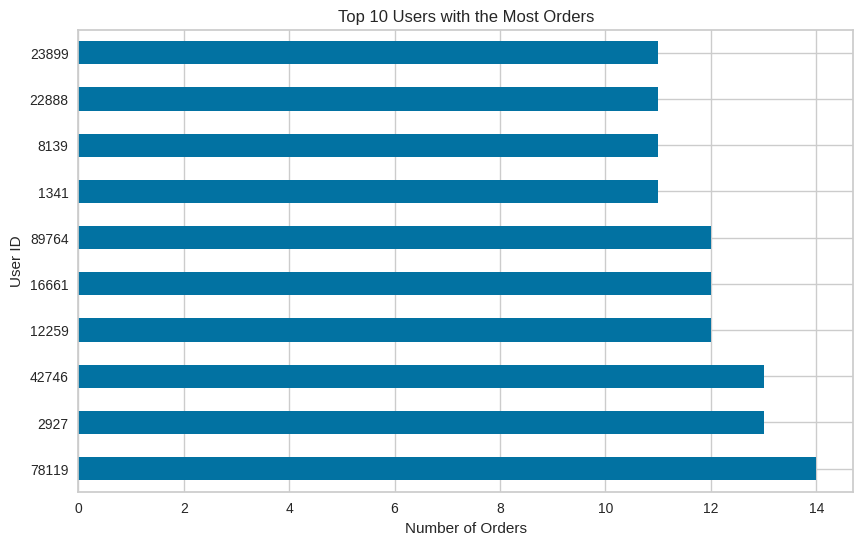

In [ ]:
# Top 10 users with the Most Orders
count_orders = df.groupby(["user_id"])["order_id"].count()
top10_users_orders = count_orders.nlargest(10)

top10_users_orders.plot(kind='barh', figsize=(10, 6))
plt.title('Top 10 Users with the Most Orders')
plt.xlabel('Number of Orders')
plt.ylabel('User ID')
plt.show()

In [ ]:
print(top10_users_orders)

user_id
78119    14
2927     13
42746    13
12259    12
16661    12
89764    12
1341     11
8139     11
22888    11
23899    11
Name: order_id, dtype: int64


The visualization and table above represent the number of orders made by different users. User with `user_id` **78119** has the highest number of orders, totaling **14**. This suggests that this particular user is a frequent or high-volume customer compared to other users in the dataset. Understanding such patterns in user behavior can be valuable for businesses. It may indicate a loyal customer, someone interested in a variety of products, or potentially a user involved in bulk or repeat purchases.

Businesses can leverage this insight by tailoring marketing strategies, loyalty programs, or personalized recommendations to enhance the user experience for high-volume customers. Recognizing and catering to the needs of such users may contribute to increased customer satisfaction and potentially boost overall sales and customer retention.

## 4.3 Average Spend

Calculating average spend per customer.

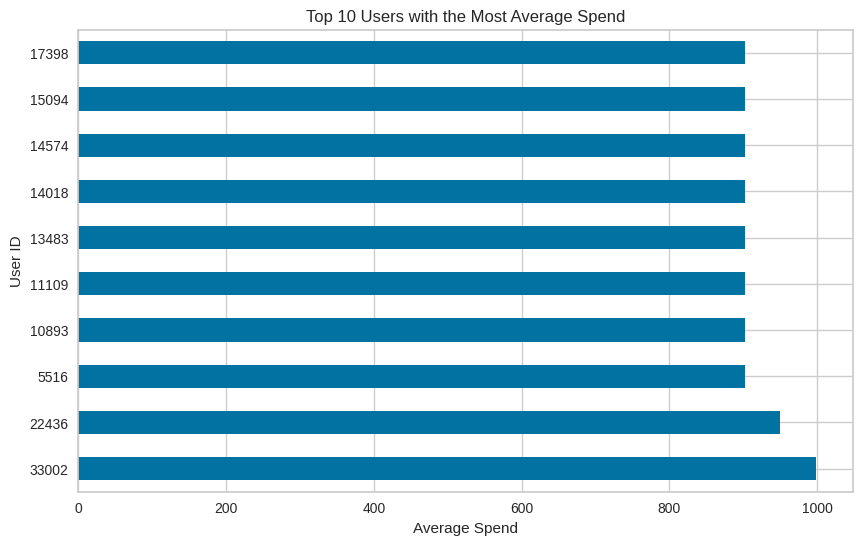

In [ ]:
# Top 10 users with the most spend
average_spend = df.groupby(["user_id"])["sale_price"].mean()
top10_users_average_spend = average_spend.nlargest(10)

top10_users_average_spend.plot(kind='barh', figsize=(10, 6))
plt.title('Top 10 Users with the Most Average Spend')
plt.xlabel('Average Spend')
plt.ylabel('User ID')
plt.show()


In [ ]:
print(top10_users_average_spend)

user_id
33002    999.0
22436    950.0
5516     903.0
10893    903.0
11109    903.0
13483    903.0
14018    903.0
14574    903.0
15094    903.0
17398    903.0
Name: sale_price, dtype: float64


The visualization and table above represent the average spend made by different users. Users with `user_id` **33002** have the highest average spending amount of **999.0**. This suggests that these specific users tend to make purchases with a higher average value compared to other users in the dataset.

For businesses, this insight is valuable as it identifies a segment of users who contribute significantly to the average spending. Understanding the spending behavior of these users can help tailor marketing strategies, loyalty programs, or personalized offers to cater to their preferences. It may also be worthwhile to analyze the product categories or types of purchases these high-spending users are making to further optimize marketing efforts or product offerings.


##  4.4 Returned Orders

Calculating total number of returned orders per customer

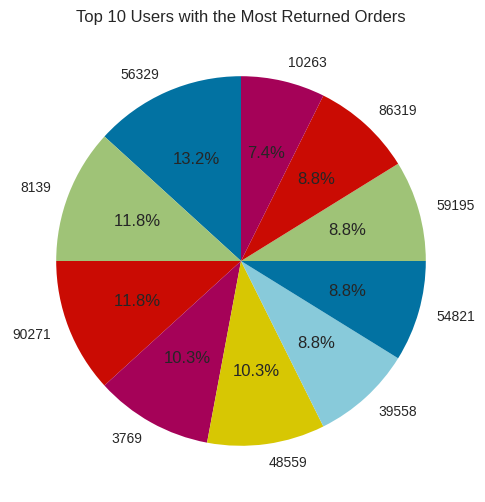

In [ ]:
# Top 10 Users with the Most Returned Orders
df["returned"] = df["status"] == "Returned"
returned = df.groupby(["user_id"])["returned"].sum()
top10_users_returned = returned.nlargest(10)

plt.figure(figsize=(10, 6))
plt.pie(top10_users_returned, labels=top10_users_returned.index, autopct='%1.1f%%', startangle=90)
plt.title('Top 10 Users with the Most Returned Orders')
plt.show()

In [ ]:
top10_users_returned

user_id
56329    9
8139     8
90271    8
3769     7
48559    7
39558    6
54821    6
59195    6
86319    6
10263    5
Name: returned, dtype: int64

The visualization and table above represent the users with the most returned orders. Users with `user_id` **56329** have 9  returned orders. This indicates that these specific users are experiencing a relatively high rate of returns compared to other users in the dataset.

For businesses, understanding which users have a significant number of returns is crucial as it may indicate potential issues such as dissatisfaction with products, sizing problems, or other reasons leading to returns. Analyzing the reasons behind these returns can help businesses identify areas for improvement, whether it's in product quality, sizing information, or other aspects of the customer experience.

## 4.5 Return Ratio

Calculating return ratio per customer. The return ratio is the percentage of orders made by a customer that are later returned.

In [ ]:
return_ratio = returned / count_orders

In [ ]:
# Compiling a conclusive dataframe for the development of a machine learning model for customer segmentation.
df_customer = count_orders.rename("count_orders").to_frame()
df_customer["average_spend"] = round(average_spend,2)
df_customer["return_ratio"] = return_ratio

df_customer.head()

,count_orders,average_spend,return_ratio
user_id,,,
1,1,18.62,0.0
3,1,25.00,0.0
4,1,189.00,0.0
5,1,189.00,0.0
8,4,51.00,1.0


The `return_ratio` provides insights into the return behavior of customers. A lower `return_ratio` suggests that a user tends to keep their purchases, while a higher `return_ratio` may indicate a greater likelihood of returning items.

The value return ratio ranging from 0.0 to 1.0. A `return_ratio` of 0.0 means that none of the user's orders were returned (no returns). A `return_ratio` of 1.0 means that all of the user's orders were returned (100% returns).

### 4.5.1 Data Inference

Data for model inference refers to the new, unseen data that trained model to make predictions or classifications on.

In [ ]:
df_inference = df_customer.sample(n=10, random_state=42)
df_inference

,count_orders,average_spend,return_ratio
user_id,,,
35346,1,50.00,0.0
18814,4,63.16,0.0
90154,1,59.45,0.0
77615,1,27.95,0.0
46295,1,25.00,0.0
61113,1,53.20,0.0
94293,2,100.00,0.0
20010,2,511.99,0.0
83044,6,89.54,0.0


In [ ]:
df_inference.to_csv('df_inference.csv')

In [ ]:
# Drop samples by index
df_customer = df_customer.drop(df_inference.index)
df_inference.to_csv('df_customer.csv')
df_customer.head()

,count_orders,average_spend,return_ratio
user_id,,,
1,1,18.62,0.0
3,1,25.00,0.0
4,1,189.00,0.0
5,1,189.00,0.0
8,4,51.00,1.0


## 4.6 Data Distribution

Understanding and identifying data distribution is crucial in data analysis as they can impact the accuracy of statistical measures and machine learning models. It's important to investigate the nature of these outliers to determine if they are valid data points or if they represent errors or anomalies that need further attention.

In [ ]:
cols = ['count_orders','average_spend','return_ratio']

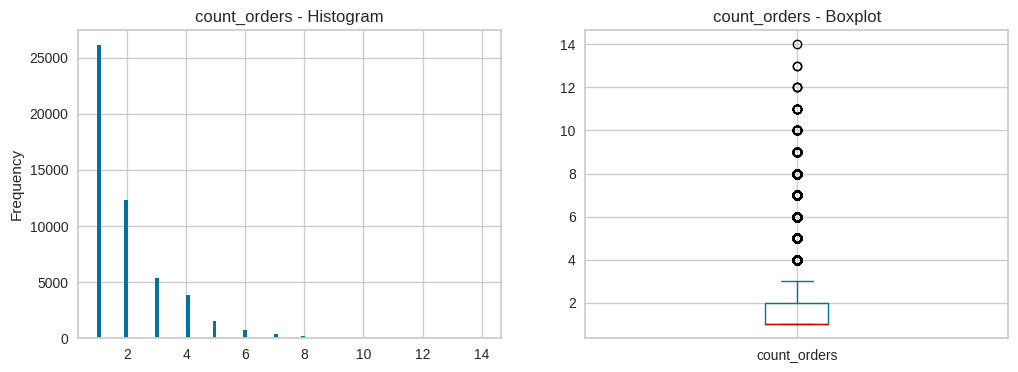

Q1:  1.0
Q3:  2.0
Number of outliers in count_orders: 6750
Percentage of outliers in count_orders: 13.37%
Skewness of count_orders: 1.89
 


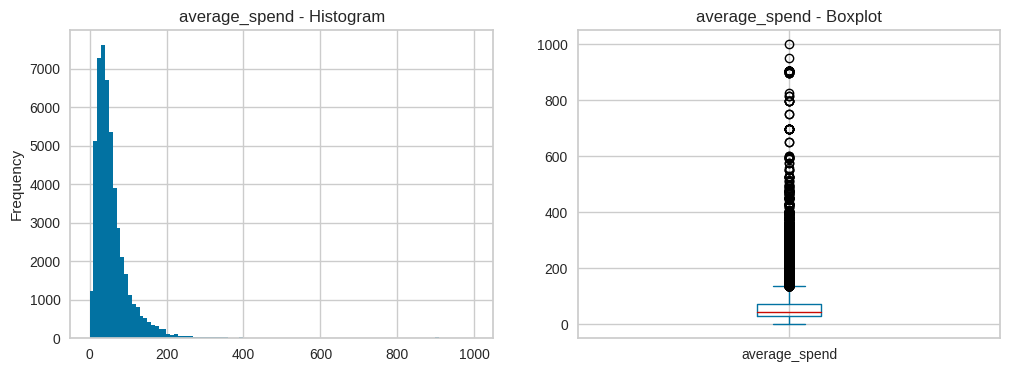

Q1:  28.55
Q3:  71.99
Number of outliers in average_spend: 3345
Percentage of outliers in average_spend: 6.63%
Skewness of average_spend: 5.34
 


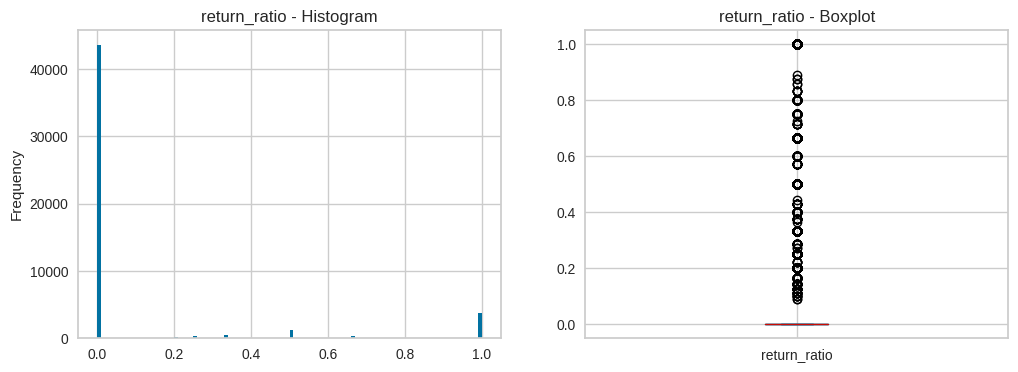

Q1:  0.0
Q3:  0.0
Number of outliers in return_ratio: 6881
Percentage of outliers in return_ratio: 13.63%
Skewness of return_ratio: 2.63
 


In [ ]:
for i in cols:
    _, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Plot histogram
    df_customer[i].plot(kind="hist", bins=100, ax=ax[0])
    ax[0].set_title(str(i) + " - Histogram")

    # Plot boxplot
    df_customer[i].plot(kind="box", ax=ax[1])
    ax[1].set_title(str(i) + " - Boxplot")

    # Calculate skewness
    skewness = skew(df_customer[i])

    plt.show()

    # Calculate IQR
    Q1 = df_customer[i].quantile(0.25)
    Q3 = df_customer[i].quantile(0.75)
    IQR = Q3 - Q1

    # Count outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_customer[(df_customer[i] < lower_bound) | (df_customer[i] > upper_bound)][i]

    # Print the number of outliers and percentage
    num_outliers = len(outliers)
    total_values = len(df_customer[i])
    percentage_outliers = (num_outliers / total_values) * 100

    print("Q1: ",Q1)
    print("Q3: ",Q3)
    print(f"Number of outliers in {i}: {len(outliers)}")
    print(f"Percentage of outliers in {i}: {percentage_outliers:.2f}%")
    print(f"Skewness of {i}: {skewness:.2f}")
    print(" ")

The histograms and boxplots show the shape of each column's data distribution. It can be seen that all columns have a skewness value > 0.5, which means that all columns have a skewed data distribution.
1. Outliers in the `count_orders` column refer to data points that significantly deviate from the typical number of orders made by users. The percentage of outliers is 13.74%, which means that approximately 13.74% of the data points in the count_orders column fall outside the expected range.
2. Outliers in the `average_spend` column indicate data points where the average spending per order is significantly different from the typical spending pattern. The percentage of outliers is 6.64%, indicating that around 6.64% of the data points in the average_spend column are considered outliers.
3. Outliers in the `return_ratio` column suggest data points where the return behavior significantly deviates from the norm. The percentage of outliers is 12.91%, meaning that approximately 12.91% of the data points in the return_ratio column are considered outliers.

---

# 5 - Feature Engineering

### 5.1 Outlier Handling

 Outlier handling is done using the Capping Method with Winsorizer library. Outlier in the `return_ratio` column is not handled because the value is <1.0 .

In [ ]:
# capping outlier if exist and in large proportion
wins = Winsorizer(capping_method='iqr', tail='both', fold=1.5)
winsorized_data = wins.fit_transform(df_customer[['count_orders','average_spend']])

In [ ]:
winsorized_data['return_ratio']= df_customer['return_ratio']

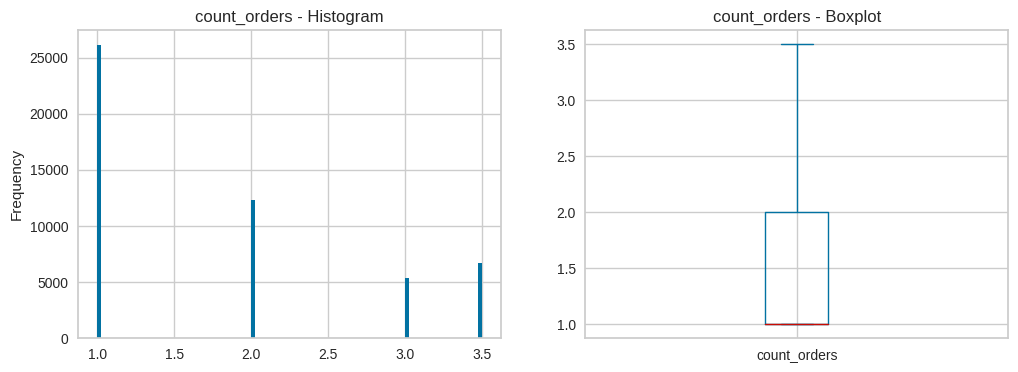

Q1:  1.0
Q3:  2.0
Number of outliers in count_orders: 0
Percentage of outliers in count_orders: 0.00%
Skewness of count_orders: 0.74
 


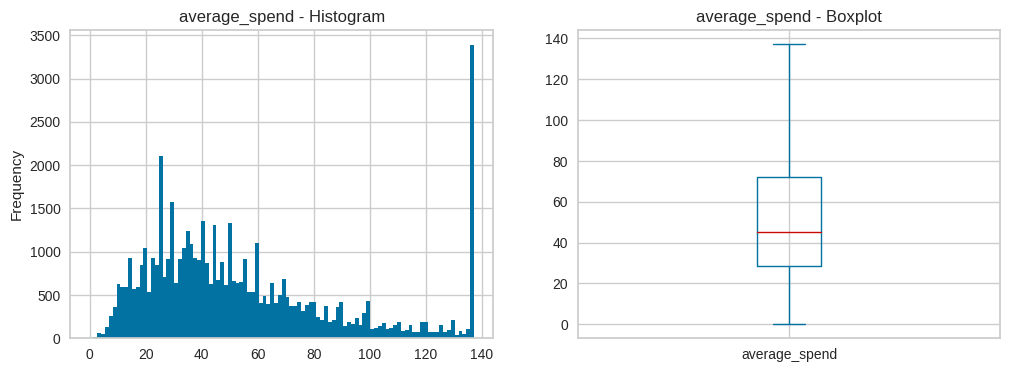

Q1:  28.55
Q3:  71.99
Number of outliers in average_spend: 0
Percentage of outliers in average_spend: 0.00%
Skewness of average_spend: 0.98
 


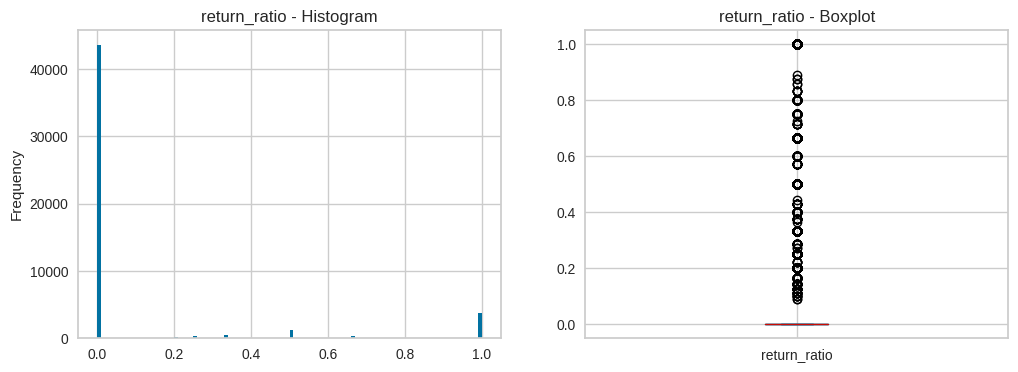

Q1:  0.0
Q3:  0.0
Number of outliers in return_ratio: 6881
Percentage of outliers in return_ratio: 13.63%
Skewness of return_ratio: 2.63
 


In [ ]:
for i in cols:
    _, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Plot histogram
    winsorized_data[i].plot(kind="hist", bins=100, ax=ax[0])
    ax[0].set_title(str(i) + " - Histogram")

    # Plot boxplot
    winsorized_data[i].plot(kind="box", ax=ax[1])
    ax[1].set_title(str(i) + " - Boxplot")

    # Calculate skewness
    skewness = skew(winsorized_data[i])

    plt.show()

    # Calculate IQR
    Q1 = winsorized_data[i].quantile(0.25)
    Q3 = winsorized_data[i].quantile(0.75)
    IQR = Q3 - Q1

    # Count outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = winsorized_data[(winsorized_data[i] < lower_bound) | (winsorized_data[i] > upper_bound)][i]

    # Print the number of outliers and percentage
    num_outliers = len(outliers)
    total_values = len(winsorized_data[i])
    percentage_outliers = (num_outliers / total_values) * 100

    print("Q1: ",Q1)
    print("Q3: ",Q3)
    print(f"Number of outliers in {i}: {len(outliers)}")
    print(f"Percentage of outliers in {i}: {percentage_outliers:.2f}%")
    print(f"Skewness of {i}: {skewness:.2f}")
    print(" ")

## 5.2 Multicollinearity

VIF (Variance Inflation Factor) measures the level of multicollinearity, which is the degree to which independent variables in a regression model are correlated. A high VIF indicates a high correlation, suggesting that the variables may be redundant or linearly dependent.

In [ ]:
# Add a constant term to the features matrix for the intercept term
X = pd.concat([winsorized_data, pd.Series(1, index=winsorized_data.index, name='const')], axis=1)

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF values
vif_data

,Variable,VIF
0,count_orders,1.003796
1,average_spend,1.003803
2,return_ratio,1.000007
3,const,6.875237


- `count_orders`, `average_spend` and `return_ratio` have VIF values close to 1, indicating low multicollinearity.
- `const`  (which represents the constant term or intercept in the regression model)  has a VIF of 6.846, which is relatively higher. This might be due to the constant term being less relevant in the context of VIF, and high VIF for the constant term alone may not be a significant concern.

## 5.3 Feature Scaling

Given that the percentage of outliers in return_ratio is relatively high (13.33%), and the skewness is 2.66, it indicates that this feature might have a non-normal distribution with some significant outliers. In such cases, using **StandardScaler** might be more appropriate, as it is less sensitive to outliers.

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(winsorized_data)

## 5.4 PCA


Principal Component Analysis (PCA) is a dimensionality reduction technique commonly used in machine learning and data analysis. It transforms high-dimensional data into a lower-dimensional representation while retaining as much of the original variability as possible. PCA achieves this by finding the principal components, which are orthogonal (uncorrelated) linear combinations of the original features.



In [ ]:
# PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# X_pca = pca.fit_transform(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

Explained Variance Ratio: [0.35384576 0.33334131 0.31281293]


- The first principal component explains approximately 35.61% of the total variance in the data.
- The second principal component explains approximately 33.34% of the total variance.
- The third principal component explains approximately 31.05% of the total variance.

In [ ]:
# Calculate the cumulative sum of explained variances
cumulative_var = np.cumsum(explained_variance_ratio)

# Find the index where cumulative variance first crosses or exceeds 95%
index_threshold = np.argmax(cumulative_var >= 0.95)

# Print the result
print("Number of components to retain 95% variance:", index_threshold + 1)

Number of components to retain 95% variance: 3


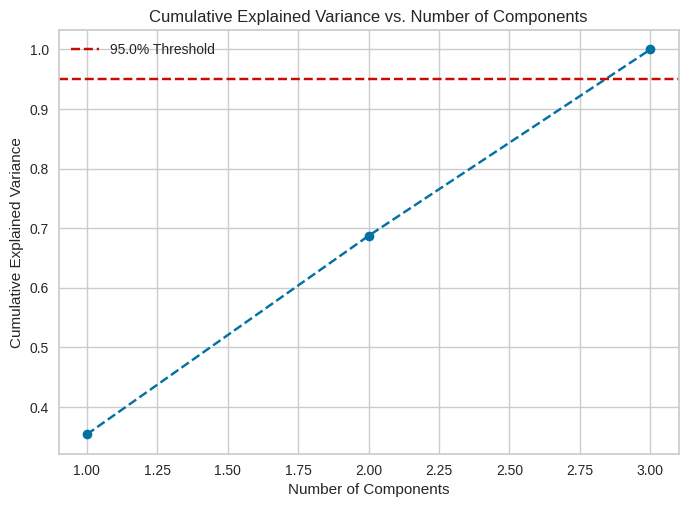

In [ ]:
# Plot the explained variance and cumulative explained variance
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')

# Draw a threshold line at 95%
threshold = 0.95
plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold * 100}% Threshold')

plt.legend()
plt.show()

First Principal Component: The first principal component contributes approximately 35.61% of the total variance.
Second Principal Component: The second principal component contributes approximately 33.34% of the total variance.
Third Principal Component: The third principal component contributes approximately 31.05% of the total variance.
When you add up these three components, you get a cumulative explained variance of approximately 35.61%+33.34%+31.05%=100%. Therefore, by using all **three principal components, you capture all the variance in the original dataset**.

In the context of dimensionality reduction using Principal Component Analysis (PCA), selecting the number of components is often a trade-off between reducing dimensionality and retaining enough information. In this case, with **three components**, you achieve a high level of information retention (95%) while reducing the dimensionality of the data.

In [ ]:
# Choose the number of components based on explained variance
n_components = 3
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

---

# 6 - Model Definition : Kmeans Clustering

K-means clustering is used in this project for customer segmentation. K-means is computationally efficient and straightforward to implement. K-means also Fast and efficient for large datasets. The metrics used are elbow method and silhoutte score. Both metrics will be compared to two conditions: without feature engineering and with feature engineering.

- **The elbow method** is a heuristic used in clustering analysis to determine the optimal number of clusters for a dataset. It involves plotting the variance or distortion as a function of the number of clusters and looking for the "elbow" point where the rate of decrease sharply changes. The idea is that the point where the decrease in variance slows down (forming an elbow shape in the plot) indicates an optimal number of clusters.

- The **silhouette score** is a metric that measures how well-defined the clusters are in a clustering algorithm, such as k-means. The silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. The optimal number of clusters corresponds to the maximum silhouette score.

## 6.1 Without Feature Engineering

### 6.1.1 Elbow Method

In [ ]:
# Train-test split
train_X, test_X = train_test_split(df_customer, test_size = 0.2,random_state=42)

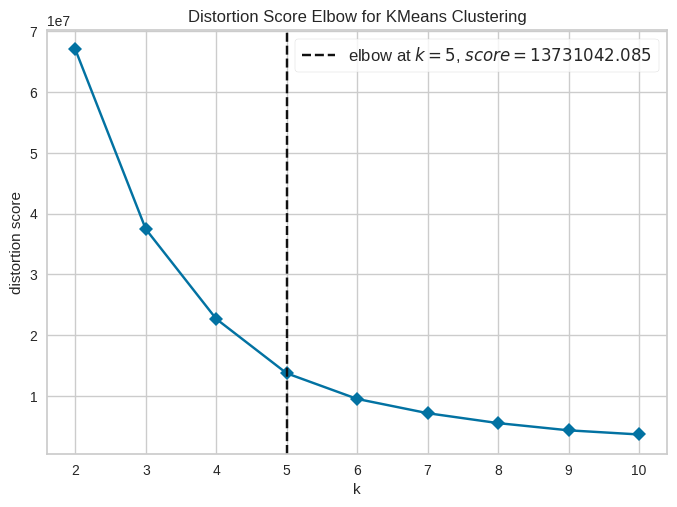

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
model = KMeans(random_state=42)

# Use the KElbowVisualizer to visualize the elbow method
visualizer = KElbowVisualizer(model, k=(2, 11), timings=False)
visualizer.fit(train_X)

# Display the visualizer
visualizer.show()

the elbow is observed at **K = 5**, and the corresponding inertia score is **13363664.732**. The elbow method suggests that K = 5 is a reasonable choice for the number of clusters because it's where the rate of decrease in inertia slows down, forming an "elbow" shape in the plot.
Beyond the elbow, the additional clusters might not significantly reduce the sum of squared distances, and the improvement in clustering quality may be marginal.

### 6.1.2 Silhoutte Score

Silhouette Score for K=2: 0.7418068394302737
Silhouette Score for K=3: 0.6680007985633829
Silhouette Score for K=4: 0.6046089083665237
Silhouette Score for K=5: 0.5809150041025
Silhouette Score for K=6: 0.5553715242115883
Silhouette Score for K=7: 0.5399485190881613
Silhouette Score for K=8: 0.5390311778941544
Silhouette Score for K=9: 0.5300993379753459
Silhouette Score for K=10: 0.5299405345440097


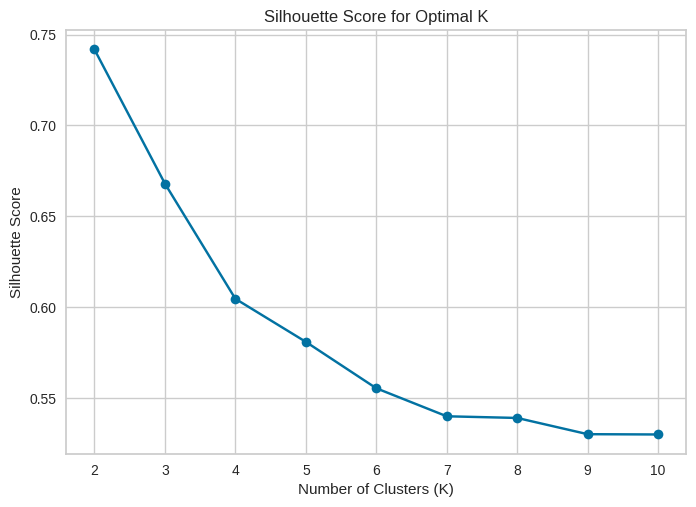

In [ ]:
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(train_X)
    kmeans_labels = kmeans.predict(df_customer)
    silhouette_scores.append(silhouette_score(df_customer, kmeans_labels))
    print(f"Silhouette Score for K={k}: {silhouette_score(df_customer, kmeans_labels)}")

# Plot the silhouette scores
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()

All of the scores are high based on the silhouette score, meaning that the object has a high match with its own cluster and a low match with its neighboring clusters.

## 6.2 With Feature Engineering

### 6.2.1 Elbow Method

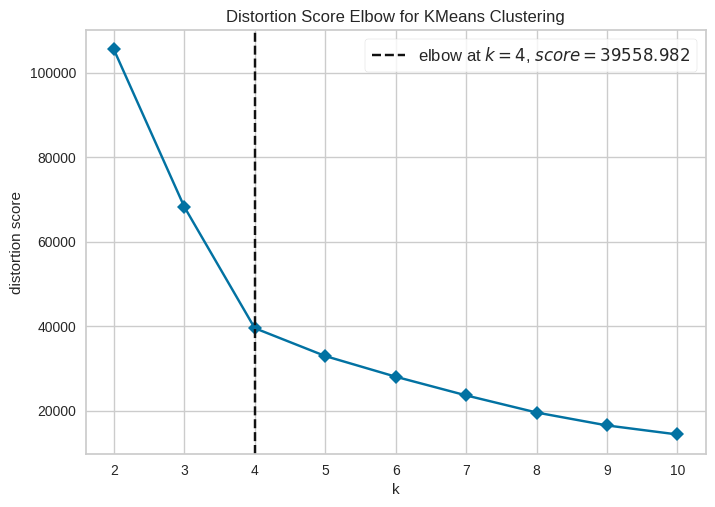

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Use the KElbowVisualizer to visualize the elbow method
visualizer_pca = KElbowVisualizer(model, k=(2, 11), timings=False)
visualizer_pca.fit(X_pca)

# Display the visualizer_pca
visualizer_pca.show()

the elbow is observed at **K = 4**, and the corresponding inertia score is **39787.934**. The elbow method suggests that K = 4 is a reasonable choice for the number of clusters because it's where the rate of decrease in inertia slows down, forming an "elbow" shape in the plot.
Beyond the elbow, the additional clusters might not significantly reduce the sum of squared distances, and the improvement in clustering quality may be marginal.

### 6.2.2 Silhoutte Score

Silhouette Score for K=2: 0.5066037441134146
Silhouette Score for K=3: 0.45616185289640404
Silhouette Score for K=4: 0.5210935881664374
Silhouette Score for K=5: 0.477209325790907
Silhouette Score for K=6: 0.4869240695727242
Silhouette Score for K=7: 0.49654132673066315
Silhouette Score for K=8: 0.5108426123037629
Silhouette Score for K=9: 0.5176400963649375
Silhouette Score for K=10: 0.5352125326224234


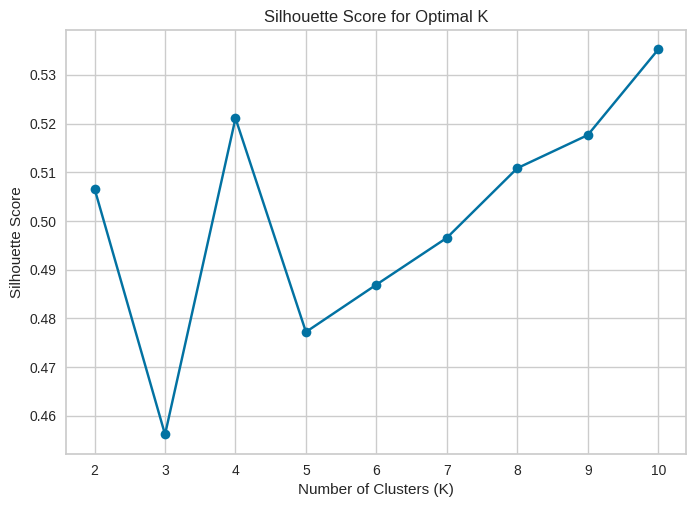

In [ ]:
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_pca)
    kmeans_labels = kmeans.predict(X_pca)
    silhouette_scores.append(silhouette_score(X_pca, kmeans_labels))
    print(f"Silhouette Score for K={k}: {silhouette_score(X_pca, kmeans_labels)}")

# Plot the silhouette scores
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()

All of the scores are high based on the silhouette score, meaning that the object has a high match with its own cluster and a low match with its neighboring clusters.


## 6.3 Best Model

Based on the comparison that has been done, the model with the condition **without feature engineering** produces a higher silhouette score.

In this e-commerce customer segmentation project, I chose the value of **k = 5** based on the results of the elbow method. The Silhoutte score of **0.594** for k = 5 suggests that the data points are relatively tightly grouped within their respective clusters and that the clusters are distinct from each other.

In [ ]:
# Number of Clusters
n_clusters = 5
model = KMeans(n_clusters = n_clusters, random_state=42)

---

# 7 - Model Evaluation

In [ ]:
# Model training
best_model = model.fit(train_X)
prediction_labels = best_model.predict(df_customer)

## Predict

In [ ]:
# Model predictions to dataframe
segments_pd = df_customer
segments_pd['segment_id'] = prediction_labels

# Rename segments
segments_pd['segment_id'] = segments_pd['segment_id'].replace({0: 1, 1: 2, 2: 3, 3: 4,4 : 5})
segments_pd.head()

,count_orders,average_spend,return_ratio,segment_id
user_id,,,,
1,1,18.62,0.0,4
3,1,25.00,0.0,4
4,1,189.00,0.0,2
5,1,189.00,0.0,2
8,4,51.00,1.0,4


In [ ]:
# save to csv
segments_pd.to_csv('df_segment.csv')

---

# 8 - EDA after Clustering

## 8.1 Number of customer per Segment

In this section, EDA is performed to determine the number of customers per segment.

1    15646
2     4397
3       78
4    29671
5      698
Name: segment_id, dtype: int64


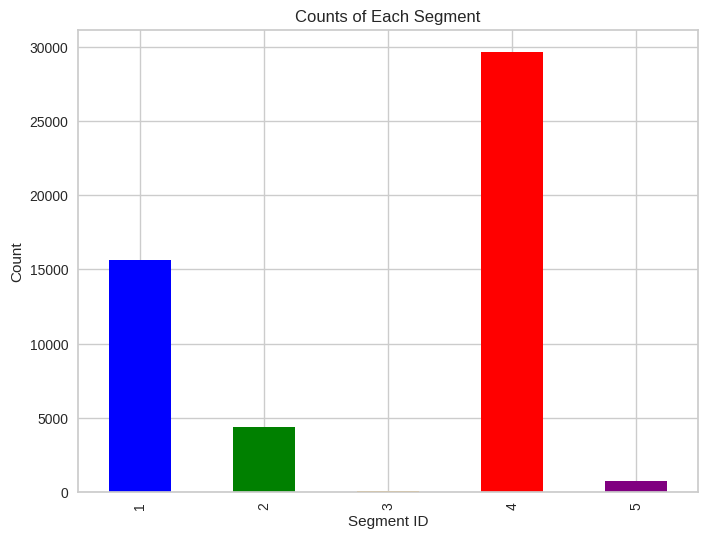

In [ ]:
# Assuming 'segments_pd' is your DataFrame
counts = segments_pd['segment_id'].value_counts().sort_index()
print(counts)

# Choose a color for each bar
colors = ['blue', 'green', 'orange', 'red', 'purple']

plt.figure(figsize=(8, 6))
counts.plot(kind='bar',color=colors)
plt.title('Counts of Each Segment')
plt.xlabel('Segment ID')
plt.ylabel('Count')
plt.show()

It can be seen from the visualization above that segment ID 4 has the highest number of customers.

##  8.2 Relationship between variable

Below is a visualization of the relationship between pairs of variables for each segment.

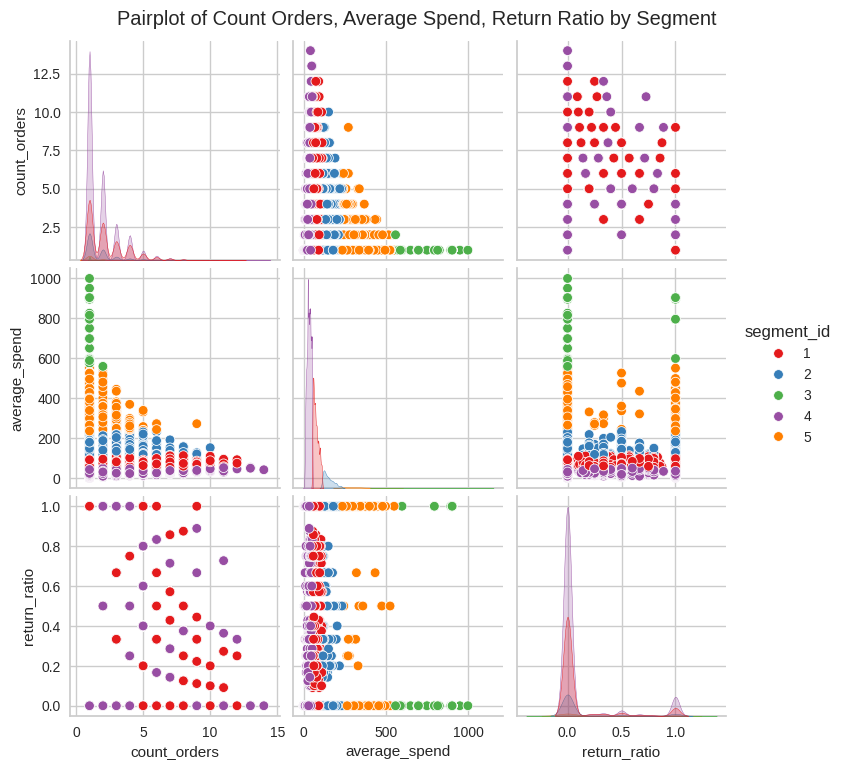

In [ ]:
# Relationship between pair of variables for each segment
sns.pairplot(segments_pd, hue='segment_id', palette='Set1')
plt.suptitle('Pairplot of Count Orders, Average Spend, Return Ratio by Segment', y=1.02)
plt.show()

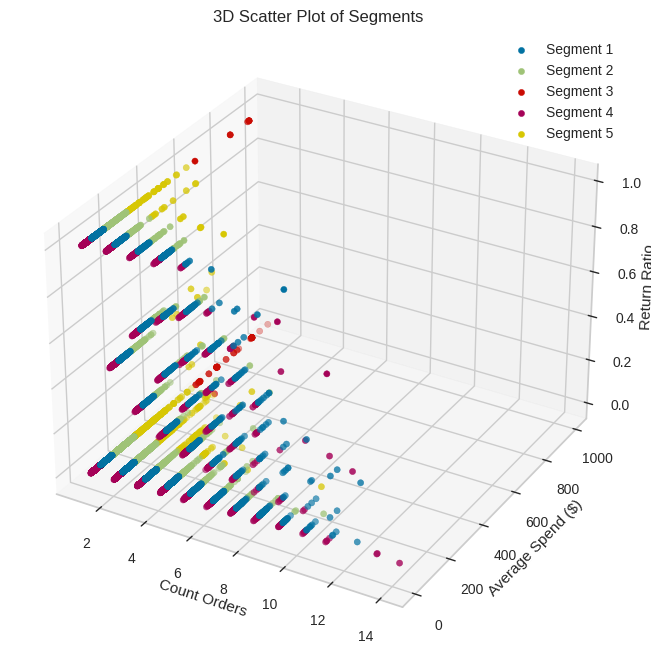

In [ ]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each segment
for segment_id, segment_data in segments_pd.groupby('segment_id'):
    ax.scatter(segment_data['count_orders'], segment_data['average_spend'], segment_data['return_ratio'], label=f'Segment {segment_id}')

# Set labels for each axis
ax.set_xlabel('Count Orders')
ax.set_ylabel('Average Spend ($)')
ax.set_zlabel('Return Ratio')

# Set the title of the plot
ax.set_title('3D Scatter Plot of Segments')

# Display the legend
ax.legend()

# Show the plot
plt.show()

## 8.3 Characteristics for each segment

### 8.3.1 Average Values per Segment

In [ ]:
# Set 'segment_id' as the index and calculate the average for each column
averages_per_segment = segments_pd.groupby('segment_id').mean()
averages_per_segment.rename(columns={'count_orders': 'average_orders_count','return_ratio':'average_return_ratio'}, inplace=True)
averages_per_segment

,average_orders_count,average_spend,average_return_ratio
segment_id,,,
1,2.272530,74.306088,0.101953
2,1.674096,150.894378,0.100605
3,1.012821,801.134487,0.102564
4,1.854976,31.243948,0.102504
5,1.438395,314.911146,0.104990


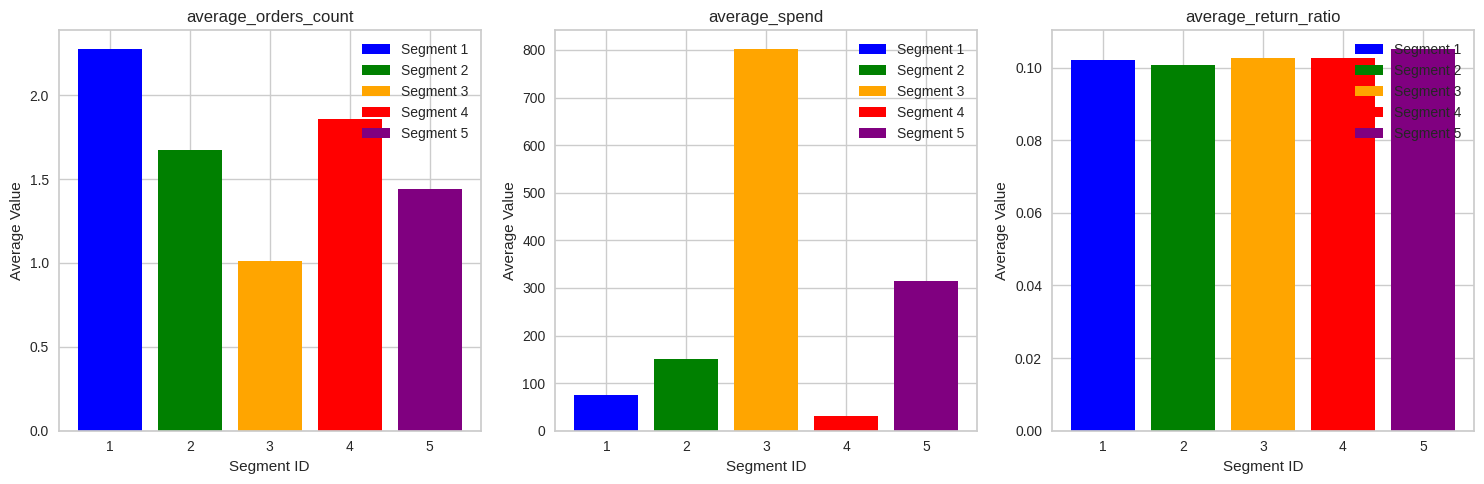

In [ ]:
# Get the number of columns in your DataFrame
num_columns = len(averages_per_segment.columns)

# Define a color dictionary mapping segment_id to a color
color_dict = {1: 'blue', 2: 'green', 3: 'orange', 4: 'red', 5: 'purple'}

# Create subplots with a number of rows based on the number of columns
fig, axes = plt.subplots(nrows=1, ncols=num_columns, figsize=(15, 5))

# Iterate over each column and plot a bar chart
for i, (column, color) in enumerate(zip(averages_per_segment.columns, sns.color_palette("husl", len(color_dict)))):
    ax = axes[i] if num_columns > 1 else axes  # Use the same axis if there's only one column
    for segment_id, segment_color in color_dict.items():
        subset = averages_per_segment.loc[averages_per_segment.index == segment_id]
        ax.bar(segment_id, subset[column].values, color=segment_color, label=f'Segment {segment_id}')

    ax.set_title(column)
    ax.set_xlabel('Segment ID')
    ax.set_ylabel('Average Value')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

### 8.3.2 Minimum and Maximum Values per segment

In [ ]:
# Set 'segment_id' as the index and calculate the minimum for each column
minimum_per_segment = segments_pd.groupby('segment_id').min()
minimum_per_segment.rename(columns={'count_orders': 'minimum_orders_count','average_spend':'minimum_average_spend','return_ratio':'minimum_return_ratio'}, inplace=True)
minimum_per_segment

,minimum_orders_count,minimum_average_spend,minimum_return_ratio
segment_id,,,
1,1,52.75,0.0
2,1,112.75,0.0
3,1,558.75,0.0
4,1,0.02,0.0
5,1,233.66,0.0


In [ ]:
# Set 'segment_id' as the index and calculate the maximum for each column
maximum_per_segment = segments_pd.groupby('segment_id').max()
maximum_per_segment.rename(columns={'count_orders': 'maximum_orders_count','average_spend':'maximum_average_spend','return_ratio':'maximum_return_ratio'}, inplace=True)
maximum_per_segment

,maximum_orders_count,maximum_average_spend,maximum_return_ratio
segment_id,,,
1,12,112.75,1.0
2,10,233.00,1.0
3,2,999.00,1.0
4,14,52.78,1.0
5,9,550.00,1.0


In [ ]:
combined_table = pd.concat([averages_per_segment,minimum_per_segment, maximum_per_segment], axis=1)
combined_table = combined_table[['minimum_orders_count','maximum_orders_count','average_orders_count','minimum_average_spend','maximum_average_spend','average_spend','minimum_return_ratio','maximum_return_ratio','average_return_ratio']]
combined_table

,minimum_orders_count,maximum_orders_count,average_orders_count,minimum_average_spend,maximum_average_spend,average_spend,minimum_return_ratio,maximum_return_ratio,average_return_ratio
segment_id,,,,,,,,,
1,1,12,2.272530,52.75,112.75,74.306088,0.0,1.0,0.101953
2,1,10,1.674096,112.75,233.00,150.894378,0.0,1.0,0.100605
3,1,2,1.012821,558.75,999.00,801.134487,0.0,1.0,0.102564
4,1,14,1.854976,0.02,52.78,31.243948,0.0,1.0,0.102504
5,1,9,1.438395,233.66,550.00,314.911146,0.0,1.0,0.104990


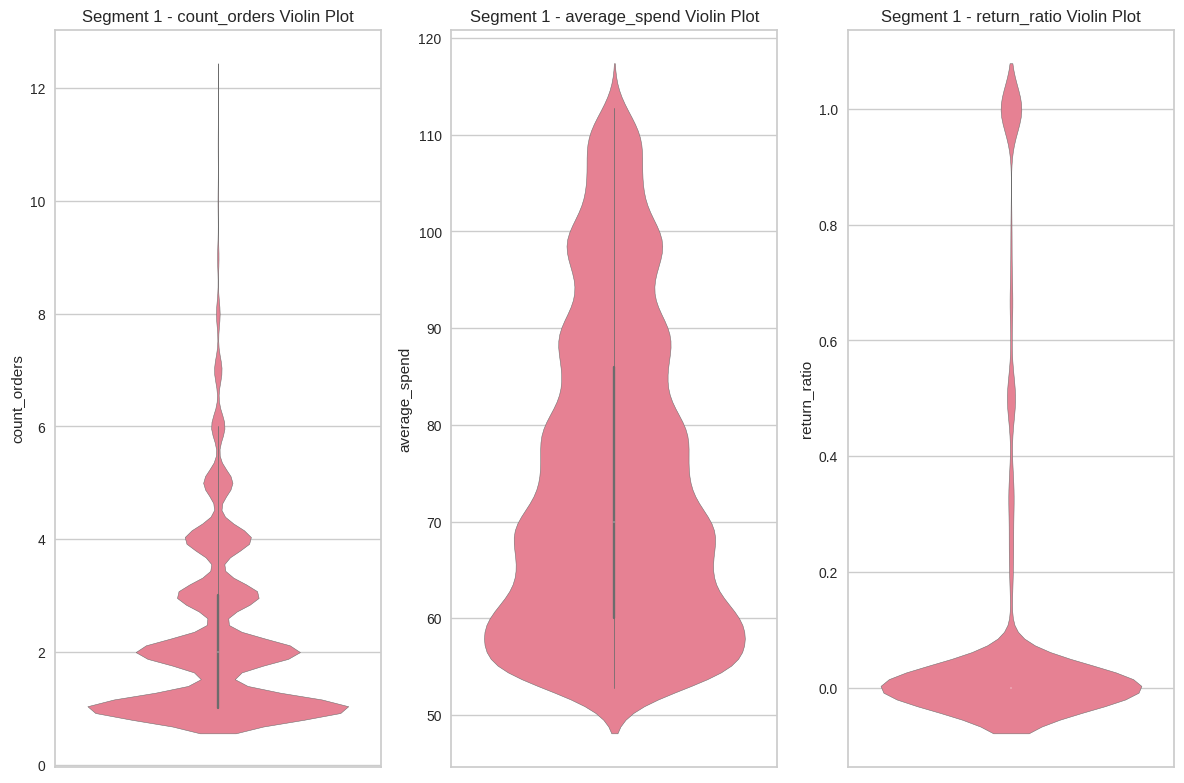

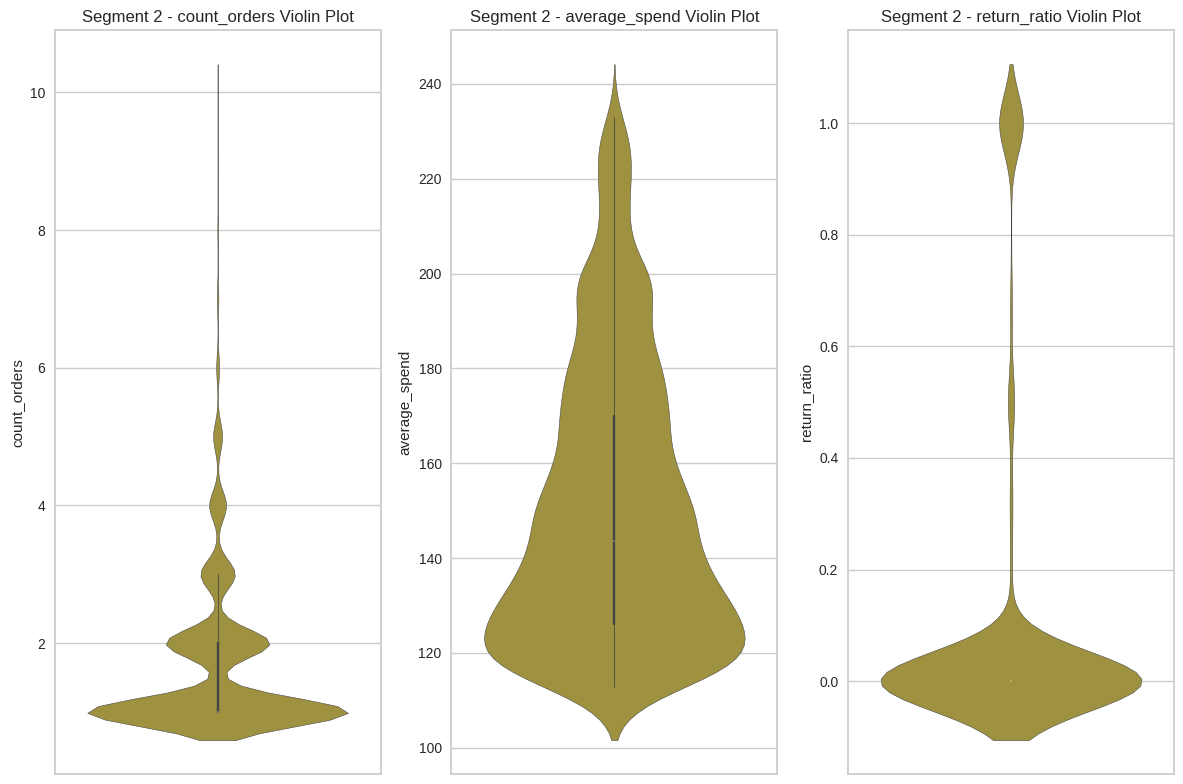

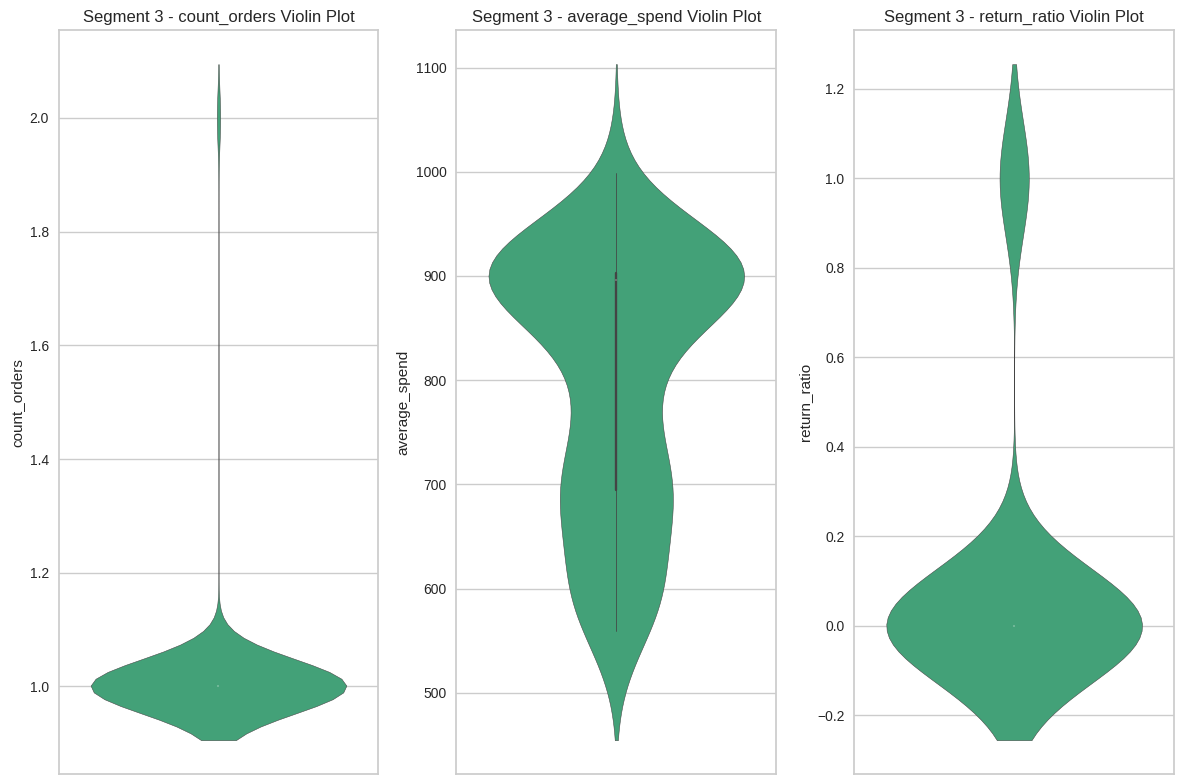

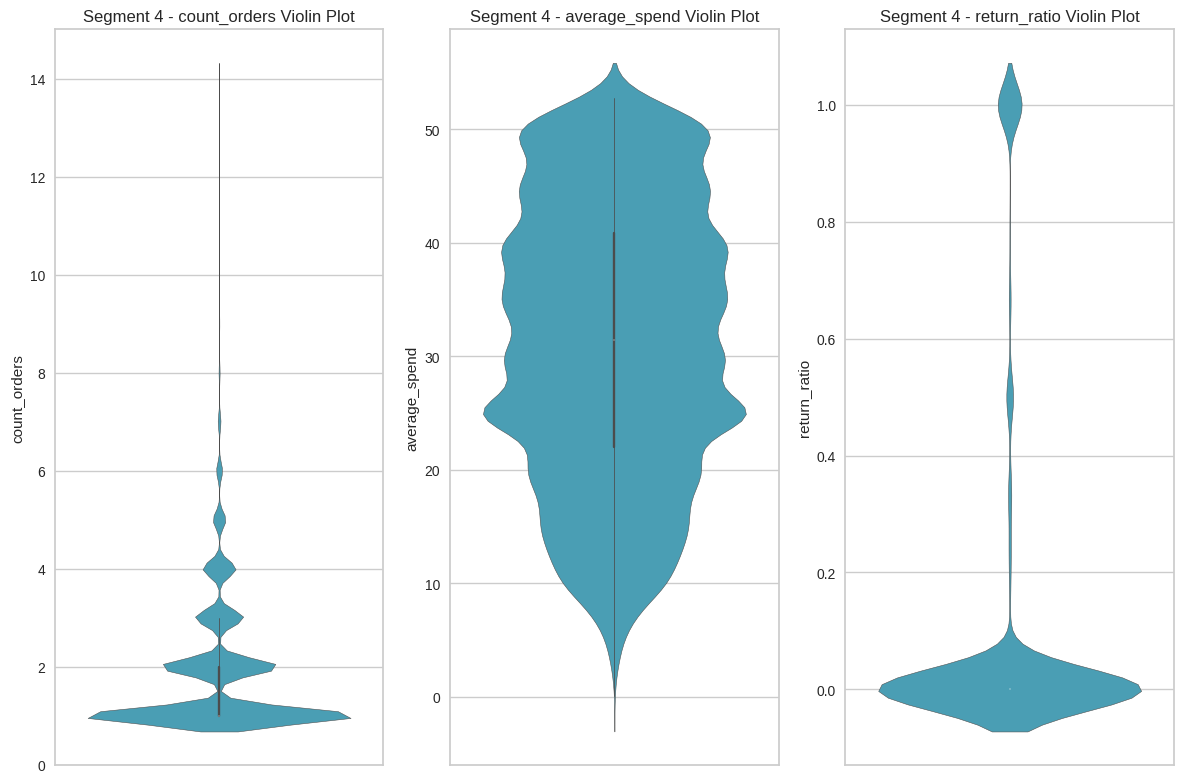

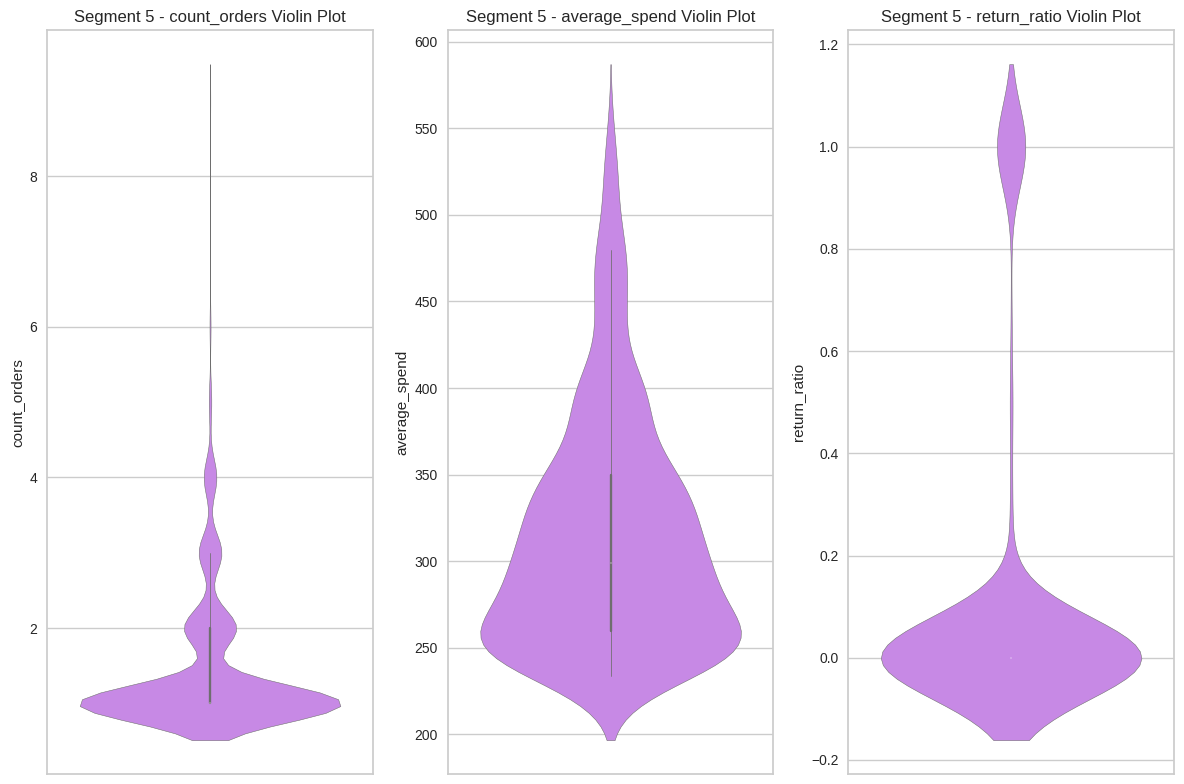

In [ ]:
# Define color palettes for each segment
segment_colors = sns.color_palette("husl", n_colors=len(segments_pd['segment_id'].unique()))

# Sort unique segment IDs
unique_segments_sorted = sorted(segments_pd['segment_id'].unique())

# Loop through each segment and column to create violinplots
for i, segment_id in enumerate(unique_segments_sorted):
    plt.figure(figsize=(12, 8))

    for j, column_name in enumerate(segments_pd.columns[:-1], start=1):  # Exclude 'user_id'
        subset_segments_pd = segments_pd[segments_pd['segment_id'] == segment_id]

        plt.subplot(1, 3, j)
        sns.violinplot(y=subset_segments_pd.loc[:,column_name], color=segment_colors[i])
        plt.title(f"Segment {segment_id} - {column_name} Violin Plot")
        print('\n')

    plt.tight_layout()
    plt.show()

In [ ]:
combined_table

,minimum_orders_count,maximum_orders_count,average_orders_count,minimum_average_spend,maximum_average_spend,average_spend,minimum_return_ratio,maximum_return_ratio,average_return_ratio
segment_id,,,,,,,,,
1,1,12,2.272530,52.75,112.75,74.306088,0.0,1.0,0.101953
2,1,10,1.674096,112.75,233.00,150.894378,0.0,1.0,0.100605
3,1,2,1.012821,558.75,999.00,801.134487,0.0,1.0,0.102564
4,1,14,1.854976,0.02,52.78,31.243948,0.0,1.0,0.102504
5,1,9,1.438395,233.66,550.00,314.911146,0.0,1.0,0.104990


In [ ]:
# Create a list to store cluster information
cluster_info = []

# Append the summary for each segment to the list
for segment_id, row in combined_table.iterrows():
    info = f"Segment {segment_id}: Spend between ${row['minimum_average_spend']:.2f} and ${row['maximum_average_spend']:.2f} with Average spend ${row['average_spend']:.2f}, Number of order per person is between: {row['minimum_orders_count']:.2f} order and {row['maximum_orders_count']:.2f} orders with average order: {row['average_orders_count']:.2f}, Return ratio is between {row['minimum_return_ratio']:.2f} and {row['maximum_return_ratio']:.2f} with average return ratio: {row['average_return_ratio']:.2f} "
    cluster_info.append(info)

# Join the list with newline characters
customer_info_string = '\n'.join(cluster_info)

# Print the result
print(customer_info_string)

Segment 1: Spend between $52.75 and $112.75 with Average spend $74.31, Number of order per person is between: 1.00 order and 12.00 orders with average order: 2.27, Return ratio is between 0.00 and 1.00 with average return ratio: 0.10 
Segment 2: Spend between $112.75 and $233.00 with Average spend $150.89, Number of order per person is between: 1.00 order and 10.00 orders with average order: 1.67, Return ratio is between 0.00 and 1.00 with average return ratio: 0.10 
Segment 3: Spend between $558.75 and $999.00 with Average spend $801.13, Number of order per person is between: 1.00 order and 2.00 orders with average order: 1.01, Return ratio is between 0.00 and 1.00 with average return ratio: 0.10 
Segment 4: Spend between $0.02 and $52.78 with Average spend $31.24, Number of order per person is between: 1.00 order and 14.00 orders with average order: 1.85, Return ratio is between 0.00 and 1.00 with average return ratio: 0.10 
Segment 5: Spend between $233.66 and $550.00 with Average s

---

# 9 - Model Saving

In [ ]:
# Saving Model Files

with open('model.pkl', 'wb') as file_1:
  pickle.dump(model, file_1)

---

# 10 - Next Marketing Strategy using Generative AI

After determining the segments of each customer, the right marketing strategy steps are needed for each customer segment. Generative AI is used to determine the marketing strategy steps for each segment.

In [ ]:
# Access the OpenAI API key
openai_api_key = 'API_KEY'

In [ ]:
clusters = str.join("\n", cluster_info)
clusters

'Segment 1: Spend between $52.75 and $112.75 with Average spend $74.31, Number of order per person is between: 1.00 order and 12.00 orders with average order: 2.27, Return ratio is between 0.00 and 1.00 with average return ratio: 0.10 \nSegment 2: Spend between $112.75 and $233.00 with Average spend $150.89, Number of order per person is between: 1.00 order and 10.00 orders with average order: 1.67, Return ratio is between 0.00 and 1.00 with average return ratio: 0.10 \nSegment 3: Spend between $558.75 and $999.00 with Average spend $801.13, Number of order per person is between: 1.00 order and 2.00 orders with average order: 1.01, Return ratio is between 0.00 and 1.00 with average return ratio: 0.10 \nSegment 4: Spend between $0.02 and $52.78 with Average spend $31.24, Number of order per person is between: 1.00 order and 14.00 orders with average order: 1.85, Return ratio is between 0.00 and 1.00 with average return ratio: 0.10 \nSegment 5: Spend between $233.66 and $550.00 with Aver

In [ ]:
prompt = f"""
You're a creative brand strategist, given the following clusters, come up with \
the next marketing action, \
explained step by step.

Clusters:
{clusters}

For each Cluster:
* Next Marketing Step:
"""

In [ ]:
prompt_template = PromptTemplate(
    input_variables=["clusters"],
    template=prompt,
)

In [ ]:
prompt_template

PromptTemplate(input_variables=[], template="\nYou're a creative brand strategist, given the following clusters, come up with the next marketing action, explained step by step.\n\nClusters:\nSegment 1: Spend between $52.75 and $112.75 with Average spend $74.31, Number of order per person is between: 1.00 order and 12.00 orders with average order: 2.27, Return ratio is between 0.00 and 1.00 with average return ratio: 0.10 \nSegment 2: Spend between $112.75 and $233.00 with Average spend $150.89, Number of order per person is between: 1.00 order and 10.00 orders with average order: 1.67, Return ratio is between 0.00 and 1.00 with average return ratio: 0.10 \nSegment 3: Spend between $558.75 and $999.00 with Average spend $801.13, Number of order per person is between: 1.00 order and 2.00 orders with average order: 1.01, Return ratio is between 0.00 and 1.00 with average return ratio: 0.10 \nSegment 4: Spend between $0.02 and $52.78 with Average spend $31.24, Number of order per person is

In [ ]:
llm = ChatOpenAI(openai_api_key=openai_api_key,model_name='gpt-3.5-turbo', temperature=0)

chain = LLMChain(
    llm=llm,
    prompt = prompt_template,
    verbose=True)

In [ ]:
response = chain.run(clusters=clusters)
print(response)



> Entering new LLMChain chain...
Prompt after formatting:

You're a creative brand strategist, given the following clusters, come up with the next marketing action, explained step by step.

Clusters:
Segment 1: Spend between $52.75 and $112.75 with Average spend $74.31, Number of order per person is between: 1.00 order and 12.00 orders with average order: 2.27, Return ratio is between 0.00 and 1.00 with average return ratio: 0.10 
Segment 2: Spend between $112.75 and $233.00 with Average spend $150.89, Number of order per person is between: 1.00 order and 10.00 orders with average order: 1.67, Return ratio is between 0.00 and 1.00 with average return ratio: 0.10 
Segment 3: Spend between $558.75 and $999.00 with Average spend $801.13, Number of order per person is between: 1.00 order and 2.00 orders with average order: 1.01, Return ratio is between 0.00 and 1.00 with average return ratio: 0.10 
Segment 4: Spend between $0.02 and $52.78 with Average spend $31.24, Number of order per p

---

## 10.1 Save Response

In [ ]:
# Save response to a text file
with open("ai_response.txt", "w") as file:
    file.write(response)

---

# 11 - Conclusion and Recommendation

1. Based on Exploratory Data Analysis.
  - There are 10.2% orders returned.
  - The highest number of orders for a customer is 14, the highest average spending for a customer is 999,  the highest returned orders for a customer is 9.
  - For businesses, understanding customer behaviour can help tailor marketing strategies.

2. Based on model evaluation:
  - The elbow point is at **k = 5**, suggests that the data points are relatively tightly grouped within their respective clusters and that the clusters are distinct from each other.
  - Silhouette score of **0.594** for k = 5 indicates that the clustering results are relatively good, with well-defined and separated clusters.

3. Based on EDA after customer segmentation:
  - **Segment 1**: Spend between 52.75 and 112.75 with Average spend 74.31, Number of order per person is between: 1.00 order and 12.00 orders with average order: 2.27, Return ratio is between 0.00 and 1.00 with average return ratio: 0.10.
  - **Segment 2**: Spend between 112.75 and 233.00 with Average spend 150.89, Number of order per person is between: 1.00 order and 10.00 orders with average order: 1.67, Return ratio is between 0.00 and 1.00 with average return ratio: 0.10.
  - **Segment 3**: Spend between 558.75 and 999.00 with Average spend 801.13, Number of order per person is between: 1.00 order and 2.00 orders with average order: 1.01, Return ratio is between 0.00 and 1.00 with average return ratio: 0.10.
  - **Segment 4**: Spend between 0.02 and 52.78 with Average spend 31.24, Number of order per person is between: 1.00 order and 14.00 orders with average order: 1.85, Return ratio is between 0.00 and 1.00 with average return ratio: 0.10.
  - **Segment 5**: Spend between 233.66 and 550.00 with Average spend 314.91, Number of order per person is between: 1.00 order and 9.00 orders with average order: 1.44, Return ratio is between 0.00 and 1.00 with average return ratio: 0.10.

4. Generative AI:
  - Marketing strategy for Segment 1: the next marketing action could be to offer personalized recommendations based on their previous purchases to encourage repeat purchases. This can be done through targeted email campaigns or personalized product suggestions on the website.

  - Marketing strategy for Segment 2: the next marketing action could be to introduce a loyalty program that rewards customers for their repeat purchases. This can include exclusive discounts, early access to new products, or special perks for being a loyal customer.

  - Marketing strategy for Segment 3: the next marketing action could be to offer high-end, exclusive products or services that cater to their premium tastes. This can include limited edition items, luxury experiences, or personalized concierge services to enhance their shopping experience and encourage repeat purchases.

  - Marketing strategy for Segment 4: the next marketing action could be to introduce a subscription service or bundle deals that offer convenience and savings for their regular purchases. This can help increase customer retention and encourage them to continue shopping with the brand.

  - Marketing strategy for Segment 5: the next marketing action could be to create exclusive VIP events or experiences for these high-value customers. This can include invitation-only sales, private shopping events, or personalized styling sessions to make them feel valued and appreciated for their loyalty to the brand.

5. Recommendations:
    
  - Customer Feedback and Improvement: Collect detailed feedback from customers, especially those with high return rates. Use this feedback to identify specific areas for improvement, whether it be product quality, sizing accuracy, or other factors contributing to returns.
